In [3]:
import io
from collections import Counter
import pandas as pd
import numpy as np
from scipy import io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin

import pydot

eps = 1e-5  # a small number

In [363]:
spam=io.loadmat('data/spam_data.mat')
spam_training=pd.DataFrame(spam['training_data'])
spam_training.columns=spam['column_names']
spam_training['training_labels']=spam['training_labels'][0]
spam_training.head()

,freq_pain_feature,freq_private_feature,freq_bank_feature,freq_money_feature,freq_drug_feature,freq_spam_feature,freq_prescription_feature,freq_creative_feature,freq_height_feature,freq_featured_feature,...,freq_record_feature,freq_out_feature,freq_semicolon_feature,freq_dollar_feature,freq_sharp_feature,freq_exclamation_feature,freq_para_feature,freq_bracket_feature,freq_and_feature,training_labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1


In [415]:
class DecisionTree:
    def __init__(self, max_depth=3, num_features=None, feature_labels=None, bagged_tree=False, random_forest=False):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.bagged_tree=bagged_tree
        self.random_forest=random_forest
        self.num_features=num_features
    @staticmethod
    def entropy(y):
        # implement entropy
        if len(y)==0:
            return 0
        p0=sum(y==0)/len(y)
        p1=sum(y==1)/len(y)
        if p0<eps or p1<eps:
            return 0
        return -p0 * np.log(p0) - p1 * np.log(p1)
    
    
    @staticmethod
    def information_gain(X, y, thresh):
        # TODO implement information gain function
        H_before = DecisionTree.entropy(y)
        y0 = y[np.where(X < thresh)[0]]
        y1 = y[np.where(X >= thresh)[0]]
        H_after = len(y0) / len(y) * DecisionTree.entropy(y0) + len(y1) / len(y) * DecisionTree.entropy(y1)
        return H_before - H_after


    @staticmethod
    def gini_impurity(X,y, thresh):
        # TODO implement gini_impurity function
        if len(y)==0:
            return 0
        p0=sum(y==0)/len(y)
        p1=sum(y==1)/len(y)
        if p0<eps or p1<eps:
            return 0
        return 1.0 - p0**2 - (1 - p0)**2     

    def purification(X, y, thresh):
        H_before=DecisionTree.gini_impurity(X,y,thresh)
        y0=y[y==0]
        p0=len(y0)/len(y)
        y0=y[y==1]
        p0=len(y1)/len(y)
        H_after=p0 * DecisionTree.gini_impurity(X,y0,thresh) + p1 * DecisionTree.gini_impurity(X,y1,thresh)
        return H_before-H_after        

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1
    
    def segmenter(self, X, y):
        # compute entropy gain for all single-dimension splits,
        # thresholding with a linear interpolation of 10 values
        gains = []
        # The following logic prevents thresholding on exactly the minimum
        # or maximum values, which may not lead to any meaningful node
        # splits.
        thresh = np.array([
            np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
            for i in range(X.shape[1])
        ])
        for i in range(X.shape[1]):
            gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

        gains = np.nan_to_num(np.array(gains))
        self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
        self.thresh = thresh[self.split_idx, thresh_idx]
        return self.split_idx, self.thresh
    
    def random_forest_segmenter(self,X,y):
        feature_index = np.random.choice(X.shape[1], self.num_features, replace=False)
        feature_index.sort()
        split_idx, thresh = self.segmenter(X[:, feature_index], y)
        self.thresh = thresh
        self.split_idx=feature_index[split_idx]
        return self.split_idx, self.thresh
        
    def fit(self, X, y):
        if self.max_depth > 0:
            if self.random_forest==True:
                split_idx, split_thresh=self.random_forest_segmenter(X, y)
            else:
                split_idx, split_thresh=self.segmenter(X, y)
            X0, y0, X1, y1 = self.split(X, y, idx=split_idx, thresh=split_thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat
    def __repr__(self, level=0):
        if self.pred is None:
            ret = "\t"*level+"level "+str(level)+' '+str(self.features[self.split_idx])+str(' < ')+str(self.thresh)+"\n"
            ret += self.left.__repr__(level+1)
            ret += self.right.__repr__(level+1)
        else:
            ret = "\t"*level+'leaf node:'+str(self.pred)+"\n"
        return ret



In [418]:
class BaggedTrees():
    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTree(feature_labels=params['feature_labels'], max_depth=params['max_depth'], bagged_tree=True)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO implement function
        for i in range(self.n):
            idx = np.random.choice(X.shape[0], X.shape[0],replace=True)
            newX, newy = X[idx, :], y[idx]
            self.decision_trees[i].fit(newX, newy)
        return self        


    def predict(self, X):
        # TODO implement function
        predictions=[self.decision_tree[i].predict(X) for i in range(self.n)]
        # not array and dtype
        average=np.round(np.mean(predctions, axis=0))
        return average
    

    

In [419]:
class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        # TODO implement function
        self.params=params
        self.n=n
        self.num_features=m
        self.decision_trees=[
            DecisionTree(feature_labels=params['feature_labels'], max_depth=params['max_depth'], num_features=m, random_forest=True)
            for i in range(self.n)
        ]
    
    def fit(self, X, y):
        # TODO implement function
        for i in range(self.n):
            idx = np.random.choice(X.shape[0], X.shape[0])
            newX, newy = X[idx, :], y[idx]
            self.decision_trees[i].fit(newX, newy)
        return self        


  
        

In [250]:
class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO implement function
        return self

    def predict(self, X):
        # TODO implement function
        pass

In [28]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append('col=' + str(col) + ' val=' + str(term[0]))
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


In [29]:

def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)

In [403]:
titanic_train = genfromtxt('data/titanic_training.csv', delimiter=',', dtype=None)
titanic_train

array([[b'survived', b'pclass', b'sex', ..., b'fare', b'cabin', b'embarked'],
       [b'0', b'3', b'male', ..., b'8.05', b'', b'S'],
       [b'0', b'1', b'male', ..., b'135.6333', b'', b'C'],
       ..., 
       [b'0', b'2', b'male', ..., b'26', b'', b'S'],
       [b'0', b'3', b'female', ..., b'39.6875', b'', b'S'],
       [b'0', b'2', b'male', ..., b'26', b'', b'S']],
      dtype='|S18')

In [404]:
y = titanic_train[1:, 0]
labeled_idx = np.where(y != b'')[0]
y = np.array(y[labeled_idx], dtype=np.int)
X, onehot_features = preprocess(titanic_train[1:, 1:], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]

In [405]:
onehot_features
#onehot_features

["col=1 val=b'male'",
 "col=1 val=b'female'",
 "col=8 val=b'S'",
 "col=8 val=b'C'",
 "col=8 val=b'Q'"]

In [406]:
titanic_final=pd.DataFrame(X,columns=['pclass','sex','age', 'sibsp','parch','ticket','fare','cabin','embark','sex=male','sex=female',
                       'embark=S','embark=C','embark=Q'])
titanic_final=titanic_final.drop(['sex', 'ticket'],axis=1)
titanic_final.head()

,pclass,age,sibsp,parch,fare,cabin,embark,sex=male,sex=female,embark=S,embark=C,embark=Q
0,3.0,-1.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,22.0,0.0,0.0,135.6333,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2.0,23.0,0.0,0.0,15.0458,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.0,42.0,0.0,0.0,13.0000,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3.0,20.0,0.0,0.0,9.8458,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## 3.3 Descripe implementation details

#### 1. How did you deal with categorical features and missing values?

I Replace missing data with the mode value because this makes more sense for categorical
features such as gender or cabin type, which are not ordered.
For categorical features, I use one-hot encoding and use indicators for each category.

#### 2. What was your stopping criterion?

I use max depth stopping criterion and tunning the best max for each tree. 

#### 3. How did you implement random forests?

My random forest implementation inherits the bagged trees which apply same learning alg 
on many random subsamples of one training set. Built upon this, random forest sample some
features to use for each tree. Implementation of random forest are based on fit and segmenter methods of DecisionTree class and and is improved with sampling points and features at same time. The final predictions are the means of each tree.

#### 4. Did you do anything special to speed up training?

I tune to hyperparameters such as depth and max_features using cross validation, 
so when fit a tree, I don't have to use every features. 
Also this helps with prevent overfitting and reduce the number of time spent and 
prevent overfitting the tree. 

#### 5. Anything else cool you implemented?

I include a repr function in decision tree to visualize the tree, so it helps me to 
understand the tree better, also help with debugging.

## 3.4 Performance Evaluation

In [407]:
from sklearn.metrics import accuracy_score

### Titanic Dataset

In [408]:
titanic_final['y']=y
titanic_final.head()

,pclass,age,sibsp,parch,fare,cabin,embark,sex=male,sex=female,embark=S,embark=C,embark=Q,y
0,3.0,-1.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,1.0,22.0,0.0,0.0,135.6333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
2,2.0,23.0,0.0,0.0,15.0458,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,2.0,42.0,0.0,0.0,13.0000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,3.0,20.0,0.0,0.0,9.8458,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [409]:
titanic_train=titanic_final.sample(frac=5/6,random_state=200)
titanic_validation=titanic_final.drop(titanic_train.index)

In [423]:
dt=DecisionTree(max_depth=3, feature_labels=list(titanic_train))
dt.fit(np.array(titanic_train.drop(['y'],axis=1)),np.array(titanic_train['y']))
dt_predictions = dt.predict(np.array(titanic_train.drop(['y'],axis=1)))
print('The training accuracy of decision tree', accuracy_score(dt_predictions,np.array(titanic_train['y'])))

The training accuracy of decision tree 0.794471153846


In [424]:
dt_predictions = dt.predict(np.array(titanic_validation.drop(['y'],axis=1)))
print('The validation accuracy of decision tree', accuracy_score(dt_predictions,np.array(titanic_validation['y'])))

The validation accuracy of decision tree 0.808383233533


In [425]:
rf=DecisionTree(max_depth=5, num_features=7,feature_labels=list(titanic_train),random_forest=True)
rf.fit(np.array(titanic_train.drop(['y'],axis=1)),np.array(titanic_train['y']))
rf_predictions = rf.predict(np.array(titanic_train.drop(['y'],axis=1)))
print('The training accuracy of random forest', accuracy_score(rf_predictions,np.array(titanic_train['y'])))

The training accuracy of random forest 0.819711538462


In [426]:
rf_predictions = rf.predict(np.array(titanic_validation.drop(['y'],axis=1)))
print('The validation accuracy of random forest', accuracy_score(rf_predictions,np.array(titanic_validation['y'])))

The validation accuracy of random forest 0.802395209581


In [184]:
validation_accuracies=[]
for depth in [1,5,10,15, 20,25,30,35,40]:
    rt=DecisionTree(max_depth=depth, num_features=7,random_forest=True)
    rt.fit(np.array(titanic_train.drop(['y'],axis=1)),np.array(titanic_train['y']))
    rt_predictions = rt.predict(np.array(titanic_validation.drop(['y'],axis=1)))
    accuracy=accuracy_score(rt_predictions,np.array(titanic_validation['y']))
    print(accuracy)
    validation_accuracies.append(accuracy)

0.796407185629
0.802395209581
0.74251497006
0.736526946108
0.712574850299
0.718562874251
0.718562874251
0.718562874251
0.718562874251


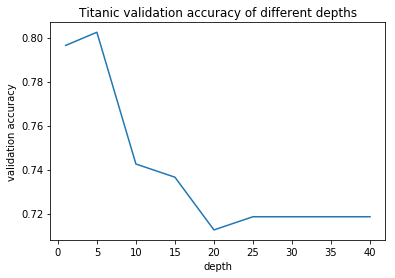

In [187]:
import matplotlib.pyplot as plt 
plt.plot([1,5,10,15, 20,25,30,35,40],validation_accuracies)
plt.xlabel('depth')
plt.ylabel('validation accuracy')
plt.title('Titanic validation accuracy of different depths')
plt.show()

In [204]:
titanic_test = genfromtxt('titanic_testing_data.csv', delimiter=',', dtype=None)

X, onehot_features = preprocess(titanic_test[1:, :], onehot_cols=[1, 5, 7, 8])

titanic_test=pd.DataFrame(X,columns=['pclass','sex','age', 'sibsp','parch','ticket','fare','cabin','embark','sex=male','sex=female',
                       'embark=S','embark=C','embark=Q'])
titanic_test=titanic_test.drop(['sex', 'ticket'],axis=1)
titanic_test.head()

,pclass,age,sibsp,parch,fare,cabin,embark,sex=male,sex=female,embark=S,embark=C,embark=Q
0,1.0,24.0,0.0,0.0,69.3000,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,44.0,0.0,1.0,57.9792,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3.0,1.0,5.0,2.0,46.9000,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3.0,29.0,0.0,0.0,7.8750,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2.0,30.0,0.0,0.0,13.0000,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [214]:
rf=DecisionTree(max_depth=5, num_features=7,feature_labels=list(titanic_train),random_forest=True)
rf.fit(np.array(titanic_train.drop(['y'],axis=1)),np.array(titanic_train['y']))
rf_predictions = rf.predict(np.array(titanic_test))

In [215]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission.csv', index_label='Id')

In [216]:
results_to_csv(rf_predictions)

### Spam Dataset

In [379]:
spam_train=spam_training.sample(frac=5/6,random_state=200)
spam_validation=spam_training.drop(spam_train.index)

In [380]:
spam_train.head()

,freq_pain_feature,freq_private_feature,freq_bank_feature,freq_money_feature,freq_drug_feature,freq_spam_feature,freq_prescription_feature,freq_creative_feature,freq_height_feature,freq_featured_feature,...,freq_record_feature,freq_out_feature,freq_semicolon_feature,freq_dollar_feature,freq_sharp_feature,freq_exclamation_feature,freq_para_feature,freq_bracket_feature,freq_and_feature,training_labels
2170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0
2798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [427]:
dt=DecisionTree(max_depth=3)
dt.fit(np.array(spam_train.drop(['training_labels'],axis=1)),np.array(spam_train['training_labels']))
dt_predictions = dt.predict(np.array(spam_train.drop(['training_labels'],axis=1)))
print('The training accuracy of decision tree', accuracy_score(dt_predictions,np.array(spam_train['training_labels'])))


The training accuracy of decision tree 0.797679814385


In [428]:
dt_predictions = dt.predict(np.array(spam_validation.drop(['training_labels'],axis=1)))
print('The validation accuracy of decision tree:', accuracy_score(dt_predictions,np.array(spam_validation['training_labels'])))

The validation accuracy of decision tree: 0.780742459397


In [429]:
rf=DecisionTree(max_depth=5, num_features=10,random_forest=True)
rf.fit(np.array(spam_train.drop(['training_labels'],axis=1)),np.array(spam_train['training_labels']))
rf_predictions = rf.predict(np.array(spam_train.drop(['training_labels'],axis=1)))
print('The training accuracy of random forest:', accuracy_score(rf_predictions,np.array(spam_train['training_labels'])))

The training accuracy of random forest: 0.805800464037


In [430]:
rf_predictions = rf.predict(np.array(spam_validation.drop(['training_labels'],axis=1)))
print('The validation accuracy of random forest:', accuracy_score(rf_predictions,np.array(spam_validation['training_labels'])))

The validation accuracy of random forest: 0.788863109049


In [220]:
validation_accuracies=[]
for depth in [1,10, 20,30,40]:
    rf=DecisionTree(max_depth=depth, num_features=8,random_forest=True)
    rf.fit(np.array(spam_train.drop(['training_labels'],axis=1)),np.array(spam_train['training_labels']))
    rf_predictions = rf.predict(np.array(spam_validation.drop(['training_labels'],axis=1)))
    accuracy=accuracy_score(rf_predictions,np.array(spam_validation['training_labels']))
    print(accuracy)
    validation_accuracies.append(accuracy)

0.722437137331
0.810444874275
0.827852998066
0.832688588008
0.830754352031


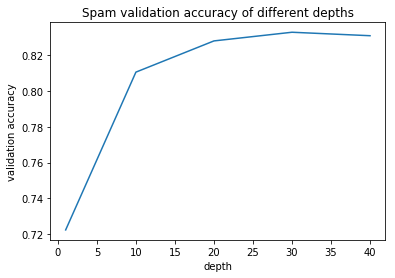

In [222]:
plt.plot([1,10, 20,30,40],validation_accuracies)
plt.xlabel('depth')
plt.ylabel('validation accuracy')
plt.title('Spam validation accuracy of different depths')
plt.show()

In [233]:
spam_test=pd.DataFrame(spam['test_data'])
spam_test.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [261]:
rf=DecisionTree(max_depth=30, num_features=8,random_forest=True)
rf.fit(np.array(spam_training.drop(['training_labels'],axis=1)),np.array(spam_training['training_labels']))
predictions=rf.predict(np.array(spam_test))

In [262]:
results_to_csv(predictions)

## 3.5 Spam Data Write Up

### Q2

In [417]:
dt=DecisionTree(max_depth=3,feature_labels=spam['column_names'])
dt.fit(np.array(spam_train.drop(['training_labels'],axis=1)),np.array(spam_train['training_labels']))

level 0 freq_exclamation_feature  < 1e-05
	level 1 freq_meter_feature        < 1e-05
		level 2 freq_para_feature         < 1e-05
			leaf node:0
			leaf node:0
		leaf node:0
	level 1 freq_meter_feature        < 1e-05
		level 2 freq_and_feature          < 1e-05
			leaf node:1
			leaf node:0
		leaf node:0

In [383]:
dt_predictions = dt.predict(np.array(spam_train.drop(['training_labels'],axis=1)))
print('The training accuracy is', accuracy_score(dt_predictions,np.array(spam_train['training_labels'])))

The training accuracy is 0.797679814385


In [384]:
spam['column_names']

array(['freq_pain_feature        ', 'freq_private_feature     ',
       'freq_bank_feature        ', 'freq_money_feature       ',
       'freq_drug_feature        ', 'freq_spam_feature        ',
       'freq_prescription_feature', 'freq_creative_feature    ',
       'freq_height_feature      ', 'freq_featured_feature    ',
       'freq_differ_feature      ', 'freq_width_feature       ',
       'freq_other_feature       ', 'freq_energy_feature      ',
       'freq_business_feature    ', 'freq_message_feature     ',
       'freq_volumes_feature     ', 'freq_revision_feature    ',
       'freq_path_feature        ', 'freq_meter_feature       ',
       'freq_memo_feature        ', 'freq_planning_feature    ',
       'freq_pleased_feature     ', 'freq_record_feature      ',
       'freq_out_feature         ', 'freq_semicolon_feature   ',
       'freq_dollar_feature      ', 'freq_sharp_feature       ',
       'freq_exclamation_feature ', 'freq_para_feature        ',
       'freq_bracket_feat

In [389]:
full=spam_train.drop(['training_labels'],axis=1)
full.columns=spam['column_names']
full['training_labels']=spam_train['training_labels']
full['prediction']=dt_predictions
show=full[['freq_exclamation_feature ','freq_meter_feature       ','freq_and_feature         ','freq_para_feature        ','training_labels',
                'prediction']]
show.loc[[2170]]

,freq_exclamation_feature,freq_meter_feature,freq_and_feature,freq_para_feature,training_labels,prediction
2170,0.0,0.0,2.0,0.0,0,0.0


In [391]:
# row of index 2170 in the table above is classified as 0
# a) exclamation feature < 1e-5
# b) meter feature < 1e-5
# c) para feature < 1e-5
# therefore this email is classified as 0[ham]



In [390]:
show.loc[[227]]

,freq_exclamation_feature,freq_meter_feature,freq_and_feature,freq_para_feature,training_labels,prediction
227,1.0,0.0,0.0,0.0,1,1.0


In [392]:
# row of index 227 in the table above is classified as 1
# a) exclamation feature > 1e-5
# b) meter feature < 1e-5
# c) para feature < 1e-5
# therefore this email is classified as 1[spam]

### Q3

In [13]:
spam_train=spam_training.sample(frac=4/5,random_state=200)
spam_validation=spam_training.drop(spam_train.index)

In [274]:
validation_accuracies=[]
for depth in [1,5,10,15, 20,25,30,35,40]:
    dt=DecisionTree(max_depth=depth)
    dt.fit(np.array(spam_train.drop(['training_labels'],axis=1)),np.array(spam_train['training_labels']))
    dt_predictions = dt.predict(np.array(spam_validation.drop(['training_labels'],axis=1)))
    accuracy=accuracy_score(dt_predictions,np.array(spam_validation['training_labels']))
    print(accuracy)
    validation_accuracies.append(accuracy)
    

0.756286266925
0.79497098646
0.818181818182
0.816247582205
0.827852998066
0.827852998066
0.832688588008
0.829787234043
0.829787234043


In [282]:
for depth in [45,50]:
    dt=DecisionTree(max_depth=depth)
    dt.fit(np.array(spam_train.drop(['training_labels'],axis=1)),np.array(spam_train['training_labels']))
    dt_predictions = dt.predict(np.array(spam_validation.drop(['training_labels'],axis=1)))
    accuracy=accuracy_score(dt_predictions,np.array(spam_validation['training_labels']))
    print(accuracy)
    validation_accuracies.append(accuracy)

0.829787234043
0.829787234043


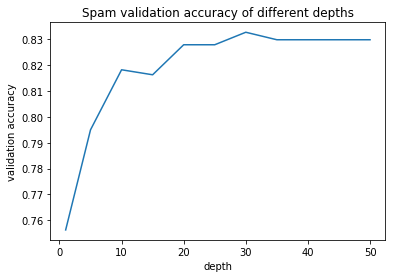

In [285]:
import matplotlib.pyplot as plt 
plt.plot([1,5,10,15, 20,25,30,35,40,45,50],validation_accuracies)
plt.xlabel('depth')
plt.ylabel('validation accuracy')
plt.title('Spam validation accuracy of different depths')
plt.show()

In [420]:
# My plot here shows depth=30 gives highest validation accuracy. If max_depth goes higher 
# than 30,validation accuracy actually goes down because tree is overfitted, so performs 
# badly for validation. 

## 3.6 Titanic Data

In [416]:
dt=DecisionTree(max_depth=3, feature_labels=list(titanic_train))
dt.fit(np.array(titanic_train.drop(['y'],axis=1)),np.array(titanic_train['y']))

level 0 sex=male < 1e-05
	level 1 pclass < 2.11111
		level 2 embark=S < 1e-05
			leaf node:1
			leaf node:1
		level 2 fare < 34.7722233333
			leaf node:1
			leaf node:0
	level 1 pclass < 1.00001
		level 2 age < 43.9999988889
			leaf node:0
			leaf node:0
		level 2 age < 32.3333344444
			leaf node:0
			leaf node:0